In [2]:
# Cloud shell에서 다음과 같이 Naver sentiment movie corpus 가지고옴
# !ln -s ~/data/*.txt ~/aiffel/sentiment_classification/data

In [3]:
# 아이펠 클라우드 서버에는 데이터가 있으나, 코랩이나 캐글로 할시에는 용량으로인해서
# 업로드가 제대로 되지 않는다.

# 이 부분은 앞으로 과제 수행하는데 있어서 어떻게 해야할지 고민을 해봐야 하는 부분!

# 1) 데이터 준비와 확인!

In [4]:
# 미리 라이브러리 import
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import re
import urllib.request
import matplotlib.pyplot as plt
from tensorflow.keras.initializers import Constant

%matplotlib inline

# 데이터 read
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head() # 데이터 확인

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [5]:
train_data.tail() # 데이터 확인

,id,document,label
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1
149999,9619869,한국 영화 최초로 수간하는 내용이 담긴 영화,0


In [6]:
# 2) 데이터 로더 구성

# 1. 데이터의 중복 제거
# 2. NaN 결측치 제거
# 3. 한국어 토크나이저로 토큰화
# 4. 불용어(Stopwords) 제거
# 5. 사전word_to_index 구성
# 6. 텍스트 스트링을 사전 인덱스 스트링으로 변환
# 7. _train, y_train, X_test, y_test, word_to_index 리턴

# 사전에 gensim 버전이 4.X.X 버전은 에러가 있다고 명시되어 있어서 
# 3.6.0 버전으로 다운그레이드 진행

In [7]:
!pip install gensim==3.6.0

  Using cached gensim-3.6.0-cp39-cp39-linux_x86_64.whl
  Attempting uninstall: gensim
    Found existing installation: gensim 3.8.3
    Uninstalling gensim-3.8.3:
      Successfully uninstalled gensim-3.8.3


In [8]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [9]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [10]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수
# 단, 모든 문장은 <BOS>로 시작하는 것으로 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [12]:
print("훈련 샘플 개수: {}, 테스트 개수: {}".format(len(X_train), len(X_test)))

훈련 샘플 개수: 146182, 테스트 개수: 49157


# 3) 모델 구성을 위한 데이터 분석 및 가공


In [13]:
# 1.데이터셋 내 문장 길이 분포
# 2.적절한 최대 문장 길이 지정
# 3.keras.preprocessing.sqeuence.pad_sequences을 활용한 패딩 추가

In [14]:
## 데이터셋 내 문장 길이 분포

더 빙 . . 진짜 짜증 나 네요 목소리
Label:  0
문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092


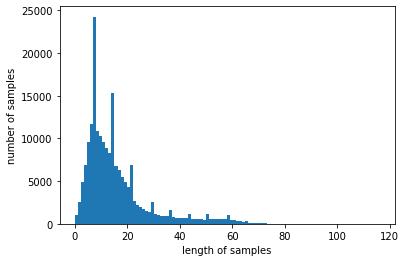

In [15]:
# decoding
print(get_decoded_sentence(X_train[0], index_to_word))
print('Label: ', y_train[0])  # 1번째 리뷰데이터의 라벨

# 텍스트데이터 문장길이의 리스트를 생성한 후
total_data_text = list(X_train) + list(X_test)

# 문장길이의 평균값, 최대값, 표준편차를 계산
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

plt.hist([len(s) for s in total_data_text], bins=100) # 가로축 구간의 개수 지정
plt.xlabel('length of samples')
plt.ylabel('number of samples')

plt.show()

## 적절한 최대 문장 길이 지정

In [16]:
# 최대 길이를 (평균 + 2*표준편차)로 가정

max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함된다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함된다. 


## keras.preprocessing.sequence.pad_sequences을 활용한 패딩 추가


In [17]:
index_to_word={}  # 빈 딕셔너리를 만들어서

# 단어들을 하나씩 채워보자. 순서는 중요하지 않다.
# <BOS>, <PAD>, <UNK>는 관례적으로 딕셔너리 맨 앞에 넣어준다
index_to_word[0]='<PAD>'  # 패딩용 단어
index_to_word[1]='<BOS>'  # 문장의 시작지점
index_to_word[2]='<UNK>'  # 사전에 없는(Unknown) 단어
index_to_word[3]='i'
index_to_word[4]='like'
index_to_word[5]='hungry'
index_to_word[6]='so'
index_to_word[7]='apple'
index_to_word[8]='happy'
index_to_word[9]='sad'

print(index_to_word)

word_to_index={word:index for index, word in index_to_word.items()}
print(word_to_index)

{0: '<PAD>', 1: '<BOS>', 2: '<UNK>', 3: 'i', 4: 'like', 5: 'hungry', 6: 'so', 7: 'apple', 8: 'happy', 9: 'sad'}
{'<PAD>': 0, '<BOS>': 1, '<UNK>': 2, 'i': 3, 'like': 4, 'hungry': 5, 'so': 6, 'apple': 7, 'happy': 8, 'sad': 9}


In [19]:
# padding
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.preprocessing import sequence
import tensorflow as tf

X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                       value=word_to_index['<PAD>'],
                                                       padding='pre',
                                                       maxlen=maxlen) # 위에서 변수로 지정된 41


X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

print(X_train.shape)

# RNN은 입력 데이터가 순차적으로 처리되어, 가장 마지막 입력이 최종 state값에 가장 영향을 많이 미치게 된다. 그래서 pro로 채우는거는 비효율적

(146182, 41)


In [20]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# 4) 모델 구성 및 validation set 구성

In [21]:
# 모델 설계
# 우선은 앞서 학습했던 것 그대로 진행.. (3개 이상 구성..)
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160000    
                                                                 
 lstm (LSTM)                 (None, 8)                 800       
                                                                 
 dense (Dense)               (None, 8)                 72        
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [22]:
# validation set 구성
# exp 학습된 코드 그대로..

# validation set 10000건 분리
X_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_X_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


# 5) 모델 훈련 개시

In [23]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs=10

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

# verbose = 학습 중 출력되는 문구를 설정
# - 0 : 아무 것도 출력X
# - 1 : 훈련의 진행도를 보여주는 진행 막대를 보여줌
# - 2 : 미니 배치마다 손실 정보를 출력.

Epoch 1/10
266/266 [==============================] - 7s 7ms/step - loss: 0.4874 - accuracy: 0.7886 - val_loss: 0.3560 - val_accuracy: 0.8494
Epoch 2/10
266/266 [==============================] - 1s 5ms/step - loss: 0.3396 - accuracy: 0.8565 - val_loss: 0.3376 - val_accuracy: 0.8532
Epoch 3/10
266/266 [==============================] - 2s 6ms/step - loss: 0.3169 - accuracy: 0.8677 - val_loss: 0.3354 - val_accuracy: 0.8551
Epoch 4/10
266/266 [==============================] - 1s 5ms/step - loss: 0.3039 - accuracy: 0.8722 - val_loss: 0.3354 - val_accuracy: 0.8535
Epoch 5/10
266/266 [==============================] - 1s 5ms/step - loss: 0.2929 - accuracy: 0.8769 - val_loss: 0.3360 - val_accuracy: 0.8533
Epoch 6/10
266/266 [==============================] - 1s 6ms/step - loss: 0.2838 - accuracy: 0.8812 - val_loss: 0.3465 - val_accuracy: 0.8497
Epoch 7/10
266/266 [==============================] - 1s 5ms/step - loss: 0.2749 - accuracy: 0.8848 - val_loss: 0.3412 - val_accuracy: 0.8524
Epoch 

In [24]:
# 모델의 fitting 과정 중의 정보들이 history 변수에 저장
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


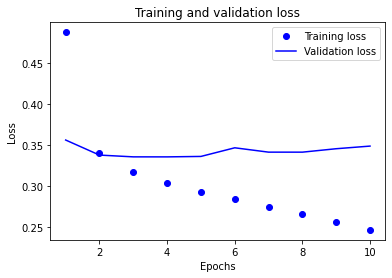

In [25]:
# "bo"는 "파란색 점"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [26]:
# Loss값 간의 Training loss와 Validation loss의 이격이 발생

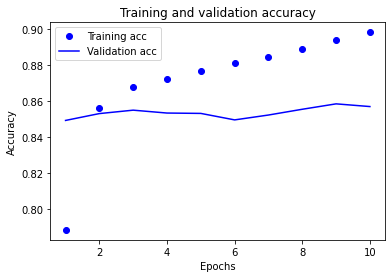

In [27]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [28]:
# Accuracy도 역시Training 과 Validation 값 사이의 이격이 발생

# 7) 학습된 Embedding 레이어 분석


In [29]:
# 모델 설계
# 우선은 앞서 학습했던 것 그대로 진행.. (3개 이상 구성..)

# model = keras.Sequential()
# model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
# model.add(keras.layers.LSTM(8))
# model.add(keras.layers.Dense(8, activation='relu'))
# model.add(keras.layers.Dense(1, activation='sigmoid'))

# model.summary()


위의 레이어에서 Dense의 각 층별로 노드숫자를 늘려줄 필요가 있어 보인다. word_vector_dim(워드벡터의 차원수도 변경 가능한 파라미터)도 늘려서 입력값들을 증가시켜준다.

마지막 출력층의 노드수는 1개 그대로 하고.. activation function들도 변경없이 그대로 가는 것이 좋을 것 같다

# 8-0) 한국어 Word2Vec 임베딩 활용하여 성능개선 직전 사전 작업

In [30]:
# https://github.com/Kyubyong/wordvectors 링크에서 한국어 임베딩 활용을 위한
# Word2Vec 다운로드

In [32]:
# !pip install --upgrade gensim==3.8.3
import gensim
print(gensim.__version__) # 3 버전 재차 확인

3.6.0


In [33]:
from gensim.models import KeyedVectors
from gensim.models.keyedvectors import Word2VecKeyedVectors

# ko.bin 파일은 ko.zip 압축을 푼후 안에 들어있는 파일임.
# 참고로 bin 파일은 압축파일이 아님
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/ko.bin'
pre_word2vec = gensim.models.Word2Vec.load(word2vec_path)

vector = pre_word2vec["과자"]
vector

pre_word2vec.similar_by_word('과자')
# pre_word2vec['사랑'].shape

/tmp/ipykernel_4441/2059462416.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vector = pre_word2vec["과자"]
/tmp/ipykernel_4441/2059462416.py:12: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  pre_word2vec.similar_by_word('과자')


[('디저트', 0.8088392019271851),
 ('소시지', 0.8049700260162354),
 ('요구르트', 0.7754430770874023),
 ('닭고기', 0.7745591402053833),
 ('아이스크림', 0.7643382549285889),
 ('야채', 0.7613315582275391),
 ('샐러드', 0.7611989378929138),
 ('케이크', 0.7551943063735962),
 ('파스타', 0.7515155076980591),
 ('돼지고기', 0.7504067420959473)]

In [34]:
pre_word2vec.similar_by_word('한국')

/tmp/ipykernel_4441/1959630309.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  pre_word2vec.similar_by_word('한국')


[('대한민국', 0.6662065982818604),
 ('우리나라', 0.6312342882156372),
 ('동양', 0.5589770078659058),
 ('미국', 0.5445788502693176),
 ('동북아', 0.5333539247512817),
 ('국내', 0.5278753638267517),
 ('일본', 0.5174024105072021),
 ('아세아', 0.5054686069488525),
 ('중국', 0.5036405920982361),
 ('민간', 0.5017623901367188)]

# 8) 한국어 Word2Vec 임베딩 활용하여 성능 개선


In [35]:
# 임베딩 레이어 변경

vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

In [36]:
# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피
for i in range(4,vocab_size):
    if index_to_word[i] in pre_word2vec:
        embedding_matrix[i] = pre_word2vec[index_to_word[i]]

/tmp/ipykernel_4441/2935459898.py:3: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in pre_word2vec:


KeyError: 10

In [37]:
# 기본 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.LSTM(16))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 41, 200)           2000000   
                                                                 
 lstm_1 (LSTM)               (None, 16)                13888     
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 2,014,033
Trainable params: 2,014,033
Non-trainable params: 0
_________________________________________________________________


In [40]:

# 모델 학습
model.compile(optimizer='adam',
              loss='binary_crossentropy', 
              metrics=['accuracy'])

epochs=15

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=4096,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/15
34/34 [==============================] - 3s 35ms/step - loss: 0.6788 - accuracy: 0.5611 - val_loss: 0.6254 - val_accuracy: 0.6833
Epoch 2/15
34/34 [==============================] - 1s 20ms/step - loss: 0.5449 - accuracy: 0.7541 - val_loss: 0.4654 - val_accuracy: 0.8030
Epoch 3/15
34/34 [==============================] - 1s 20ms/step - loss: 0.4245 - accuracy: 0.8220 - val_loss: 0.3925 - val_accuracy: 0.8330
Epoch 4/15
34/34 [==============================] - 1s 20ms/step - loss: 0.3648 - accuracy: 0.8492 - val_loss: 0.3644 - val_accuracy: 0.8423
Epoch 5/15
34/34 [==============================] - 1s 20ms/step - loss: 0.3391 - accuracy: 0.8605 - val_loss: 0.3528 - val_accuracy: 0.8482
Epoch 6/15
34/34 [==============================] - 1s 21ms/step - loss: 0.3209 - accuracy: 0.8693 - val_loss: 0.3543 - val_accuracy: 0.8459
Epoch 7/15
34/34 [==============================] - 1s 20ms/step - loss: 0.3117 - accuracy: 0.8727 - val_loss: 0.3490 - val_accuracy: 0.8477
Epoch 8/15
34

In [42]:
# 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.3747 - accuracy: 0.8454 - 4s/epoch - 2ms/step
[0.3746548891067505, 0.8454136848449707]


In [43]:
# 모델의 fitting 과정 중의 정보들이 history 변수에 저장
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [44]:
# 도식화 Training and Validation loss
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

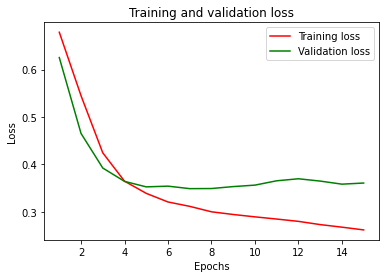

In [49]:
# "red"는 "파란색 실선"이다
plt.plot(epochs, loss, 'red', label='Training loss')
# 'g'는 "녹색 실선"이다
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

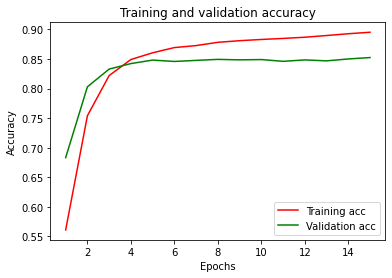

In [50]:

# Training and Validation accuracy
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
# 모델 구성 경우의 수

# 우선 순수 LSTM 층에서의 base 결과물
# 1-D CNN이 들어간 부분과
# MAxPooling1D가 들어가야 할 것으로 보인다.


In [84]:
# 모델 구성

# 기본 LSTM
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.LSTM(12))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid')) # binary classification이라서 마지막 레이어에서 

model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 41, 200)           2000000   
                                                                 
 lstm_13 (LSTM)              (None, 12)                10224     
                                                                 
 dense_18 (Dense)            (None, 8)                 104       
                                                                 
 dense_19 (Dense)            (None, 1)                 9         
                                                                 
Total params: 2,010,337
Trainable params: 2,010,337
Non-trainable params: 0
_________________________________________________________________


In [85]:
# 모델 학습
model.compile(optimizer='adam',
              loss='binary_crossentropy', 
              metrics=['accuracy'])

epochs=20

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=4096,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
34/34 [==============================] - 3s 48ms/step - loss: 0.6700 - accuracy: 0.6055 - val_loss: 0.6118 - val_accuracy: 0.7082
Epoch 2/20
34/34 [==============================] - 1s 20ms/step - loss: 0.5516 - accuracy: 0.7644 - val_loss: 0.4872 - val_accuracy: 0.8008
Epoch 3/20
34/34 [==============================] - 1s 20ms/step - loss: 0.4458 - accuracy: 0.8247 - val_loss: 0.4209 - val_accuracy: 0.8328
Epoch 4/20
34/34 [==============================] - 1s 20ms/step - loss: 0.3880 - accuracy: 0.8492 - val_loss: 0.3909 - val_accuracy: 0.8373
Epoch 5/20
34/34 [==============================] - 1s 20ms/step - loss: 0.3579 - accuracy: 0.8607 - val_loss: 0.3995 - val_accuracy: 0.8333
Epoch 6/20
34/34 [==============================] - 1s 20ms/step - loss: 0.3418 - accuracy: 0.8655 - val_loss: 0.3679 - val_accuracy: 0.8471
Epoch 7/20
34/34 [==============================] - 1s 20ms/step - loss: 0.3222 - accuracy: 0.8754 - val_loss: 0.3734 - val_accuracy: 0.8393
Epoch 8/20
34

In [86]:
# 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.3943 - accuracy: 0.8377 - 4s/epoch - 3ms/step
[0.39430806040763855, 0.8377443552017212]


In [87]:
# 모델의 fitting 과정 중의 정보들이 history 변수에 저장
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [88]:
# 도식화 Training and Validation loss
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

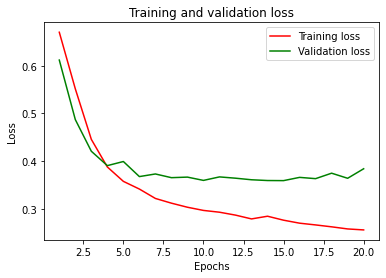

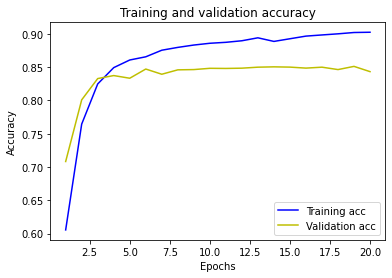

In [93]:
# "r"는 "빨간색 실선"이다
plt.plot(epochs, loss, 'r', label='Training loss')
# 'g'는 "녹색 실선"이다
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.subplot()
# "r"는 "파란 실선"이다
plt.plot(epochs, acc, 'b', label='Training acc')
# "ㅛ"는 "노란 실선"이다
plt.plot(epochs, val_acc, 'y', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [94]:
#  LSTM 에 Conv1D 조합
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.Conv1D(8, 5, activation='relu'))
model.add(keras.layers.LSTM(12))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid')) # binary classification이라서 마지막 레이어에서 

model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 41, 200)           2000000   
                                                                 
 conv1d_5 (Conv1D)           (None, 37, 8)             8008      
                                                                 
 lstm_14 (LSTM)              (None, 12)                1008      
                                                                 
 dense_20 (Dense)            (None, 8)                 104       
                                                                 
 dense_21 (Dense)            (None, 1)                 9         
                                                                 
Total params: 2,009,129
Trainable params: 2,009,129
Non-trainable params: 0
_________________________________________________________________


In [95]:
# 모델 학습
model.compile(optimizer='adam',
              loss='binary_crossentropy', 
              metrics=['accuracy'])

epochs=20

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=4096,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
34/34 [==============================] - 3s 39ms/step - loss: 0.6866 - accuracy: 0.5645 - val_loss: 0.6689 - val_accuracy: 0.6345
Epoch 2/20
34/34 [==============================] - 1s 24ms/step - loss: 0.6302 - accuracy: 0.7101 - val_loss: 0.5790 - val_accuracy: 0.7603
Epoch 3/20
34/34 [==============================] - 1s 24ms/step - loss: 0.5177 - accuracy: 0.7785 - val_loss: 0.4556 - val_accuracy: 0.8053
Epoch 4/20
34/34 [==============================] - 1s 24ms/step - loss: 0.4226 - accuracy: 0.8212 - val_loss: 0.3986 - val_accuracy: 0.8266
Epoch 5/20
34/34 [==============================] - 1s 24ms/step - loss: 0.3778 - accuracy: 0.8413 - val_loss: 0.3780 - val_accuracy: 0.8369
Epoch 6/20
34/34 [==============================] - 1s 24ms/step - loss: 0.3584 - accuracy: 0.8498 - val_loss: 0.3718 - val_accuracy: 0.8338
Epoch 7/20
34/34 [==============================] - 1s 24ms/step - loss: 0.3346 - accuracy: 0.8618 - val_loss: 0.3689 - val_accuracy: 0.8380
Epoch 8/20
34

In [96]:
# 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.3772 - accuracy: 0.8429 - 4s/epoch - 3ms/step
[0.37719032168388367, 0.842870831489563]


In [97]:
# 모델의 fitting 과정 중의 정보들이 history 변수에 저장
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [98]:
# 도식화 Training and Validation loss
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

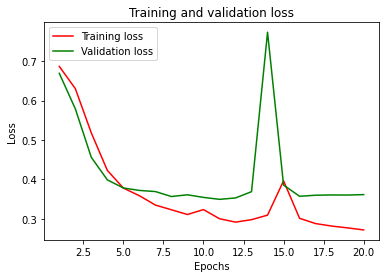

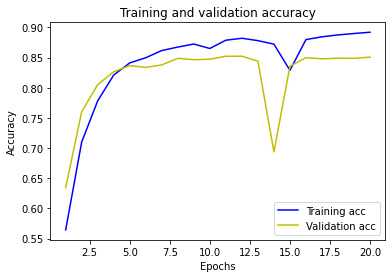

In [99]:
# "r"는 "빨간색 실선"이다
plt.plot(epochs, loss, 'r', label='Training loss')
# 'g'는 "녹색 실선"이다
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.subplot()
# "r"는 "파란 실선"이다
plt.plot(epochs, acc, 'b', label='Training acc')
# "ㅛ"는 "노란 실선"이다
plt.plot(epochs, val_acc, 'y', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [100]:
#  LSTM 에 MaxPooling1D 조합
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.LSTM(12))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid')) # binary classification이라서 마지막 레이어에서 

model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 41, 200)           2000000   
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 8, 200)           0         
 1D)                                                             
                                                                 
 lstm_15 (LSTM)              (None, 12)                10224     
                                                                 
 dense_22 (Dense)            (None, 8)                 104       
                                                                 
 dense_23 (Dense)            (None, 1)                 9         
                                                                 
Total params: 2,010,337
Trainable params: 2,010,337
Non-trainable params: 0
___________________________________________

In [101]:
# 모델 학습
model.compile(optimizer='adam',
              loss='binary_crossentropy', 
              metrics=['accuracy'])

epochs=20

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=4096,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
34/34 [==============================] - 3s 36ms/step - loss: 0.6646 - accuracy: 0.6067 - val_loss: 0.6153 - val_accuracy: 0.6943
Epoch 2/20
34/34 [==============================] - 1s 22ms/step - loss: 0.5633 - accuracy: 0.7407 - val_loss: 0.5259 - val_accuracy: 0.7564
Epoch 3/20
34/34 [==============================] - 1s 22ms/step - loss: 0.4672 - accuracy: 0.7968 - val_loss: 0.4456 - val_accuracy: 0.8070
Epoch 4/20
34/34 [==============================] - 1s 22ms/step - loss: 0.4077 - accuracy: 0.8274 - val_loss: 0.4184 - val_accuracy: 0.8122
Epoch 5/20
34/34 [==============================] - 1s 22ms/step - loss: 0.3688 - accuracy: 0.8463 - val_loss: 0.3864 - val_accuracy: 0.8304
Epoch 6/20
34/34 [==============================] - 1s 22ms/step - loss: 0.3405 - accuracy: 0.8586 - val_loss: 0.3756 - val_accuracy: 0.8339
Epoch 7/20
34/34 [==============================] - 1s 22ms/step - loss: 0.3184 - accuracy: 0.8694 - val_loss: 0.3670 - val_accuracy: 0.8399
Epoch 8/20
34

In [102]:
# 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.4591 - accuracy: 0.8289 - 3s/epoch - 2ms/step
[0.45908379554748535, 0.8289358615875244]


In [103]:
# 모델의 fitting 과정 중의 정보들이 history 변수에 저장
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [104]:
# 도식화 Training and Validation loss
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

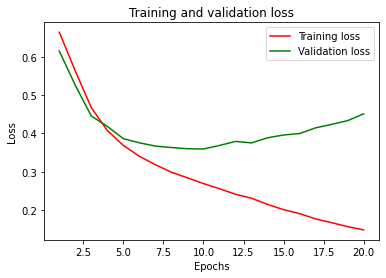

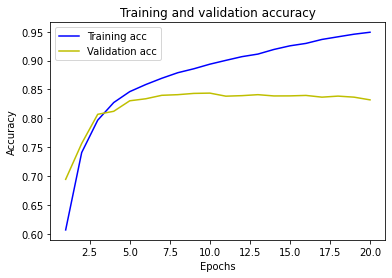

In [105]:
# "r"는 "빨간색 실선"이다
plt.plot(epochs, loss, 'r', label='Training loss')
# 'g'는 "녹색 실선"이다
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.subplot()
# "r"는 "파란 실선"이다
plt.plot(epochs, acc, 'b', label='Training acc')
# "ㅛ"는 "노란 실선"이다
plt.plot(epochs, val_acc, 'y', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [106]:
#  LSTM 에 MaxPooling1D + 1D-CNN조합 (짬뽕 조합)
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.Conv1D(8, 5, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.LSTM(12))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid')) # binary classification이라서 마지막 레이어에서 

model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, 41, 200)           2000000   
                                                                 
 conv1d_6 (Conv1D)           (None, 37, 8)             8008      
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 7, 8)             0         
 1D)                                                             
                                                                 
 lstm_16 (LSTM)              (None, 12)                1008      
                                                                 
 dense_24 (Dense)            (None, 8)                 104       
                                                                 
 dense_25 (Dense)            (None, 1)                 9         
                                                     

In [107]:
# 모델 학습
model.compile(optimizer='adam',
              loss='binary_crossentropy', 
              metrics=['accuracy'])

epochs=20

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=4096,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
34/34 [==============================] - 3s 35ms/step - loss: 0.6924 - accuracy: 0.5193 - val_loss: 0.6887 - val_accuracy: 0.5520
Epoch 2/20
34/34 [==============================] - 1s 20ms/step - loss: 0.6752 - accuracy: 0.6246 - val_loss: 0.6478 - val_accuracy: 0.6876
Epoch 3/20
34/34 [==============================] - 1s 20ms/step - loss: 0.5961 - accuracy: 0.7292 - val_loss: 0.5492 - val_accuracy: 0.7444
Epoch 4/20
34/34 [==============================] - 1s 20ms/step - loss: 0.4982 - accuracy: 0.7749 - val_loss: 0.4705 - val_accuracy: 0.7833
Epoch 5/20
34/34 [==============================] - 1s 20ms/step - loss: 0.4429 - accuracy: 0.8004 - val_loss: 0.4418 - val_accuracy: 0.7932
Epoch 6/20
34/34 [==============================] - 1s 20ms/step - loss: 0.4026 - accuracy: 0.8235 - val_loss: 0.4217 - val_accuracy: 0.8019
Epoch 7/20
34/34 [==============================] - 1s 20ms/step - loss: 0.3782 - accuracy: 0.8363 - val_loss: 0.4136 - val_accuracy: 0.8053
Epoch 8/20
34

In [108]:
# 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.4759 - accuracy: 0.8017 - 4s/epoch - 2ms/step
[0.4758967161178589, 0.8017169237136841]


In [109]:
# 모델의 fitting 과정 중의 정보들이 history 변수에 저장
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [110]:
# 도식화 Training and Validation loss
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

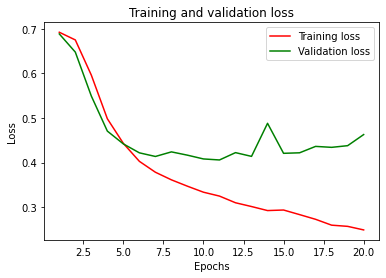

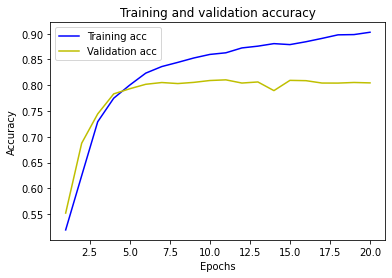

In [111]:
# "r"는 "빨간색 실선"이다
plt.plot(epochs, loss, 'r', label='Training loss')
# 'g'는 "녹색 실선"이다
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.subplot()
# "r"는 "파란 실선"이다
plt.plot(epochs, acc, 'b', label='Training acc')
# "ㅛ"는 "노란 실선"이다
plt.plot(epochs, val_acc, 'y', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# 총평

Word2Vec 임베딩을 통해서 accuracy 자체가 증가한지는 모르겠다
우선은 3가지의 조합으로 시도를 해보았으나, base 모델인 LSTM만 쓴것을 제외하고는 validation과 test값의 격차가 있어서 정확도는 85%가 넘어가지만, 신뢰할수 있는 데이터인지는 모르겠다.

각각의 모델 조합은 핸즈온 머신러닝과 모두의 딥러닝 책들을 보면서 하였으나, 각각의 모델에서 몇층 모델에 어떠한 것을 넣는것이 좋고 구체적인 파라미터는 어떻게 하여야 하는지 각각 따져가며 경우의수를 따지며 결과를 보며 체감하는 것이 좋으나, 시간상 그렇게 하지는 못하였다.

그래도 우선 구동을 시켜보면서 어떠한 함수가 어떤 특징을 가지고 있는지를 찾아보며 공부를 할수 있는 시간이었고, 한가지 아쉬운점은 compile()할때의 조건들을 변화시켜보지 못한것도 아쉽다. (일종의 통제변인으로 작용했지만, 모델조합은 그대로해놓고 조작변인으로 돌려보면, 좀더 원리를 직접 알수 있지 않을까 생각한다.)

결국 딥러닝의 전반적인 큰 그림과 상세한 구동원리까지 알아야 하는건데, 아직까지는 부족한 점이 많아 보인다.
노드로 돌아가서 복습할 부분과 정리할 부분들 선별하여 머릿속에 정리를 하여서 다시 한번 해봐야겠다는 생각이 들었다.

자연어 처리는 사실 너무 어렵다는 생각도 든다.

루브릭 평가문항에서는
1. 다양한 방법으로 Text Classification 태스크를 성공적으로 구현하였다.
-> 우선적으로 별 오류없이 구동이 되어서 평가기준을 충족하는거 같고

2. gensim을 활용하여 자체학습된 혹은 사전학습된 임베딩 레이어를 분석하였다.
-> 사전에 나라이름이나 음식이름으로 유사단어찾기도 성공하였다.

3.  한국어 Word2Vec을 활용하여 가시적인 성능향상을 달성했다.
-> 이와같은 경우에는 validation과 test set의 편차가 있는 편인지라 잘은 모르겠으나, 한번 물어보고 찾아보고 분석이 필요할꺼 같아 보인다.